In [13]:
# 基础的调用方法
## 案例1:简单的MLP模型
#  maximize
#        x + y + 2z
#  subject to
#        x + 2 y + 3 z <= 4
#        x +   y       >= 1
#        x, y, z binary

import gurobipy as gp
from gurobipy import GRB

try:
    # 创建模型
    m = gp.Model("mip1")

    # 创建决策变量
    x = m.addVar(vtype=GRB.BINARY, name="x")
    y = m.addVar(vtype=GRB.BINARY, name="y")
    z = m.addVar(vtype=GRB.BINARY, name="z")
    # 设置目标函数
    m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)
    # 增加模型约束
    m.addConstr(x + 2 * y + 3 * z <= 4, "c0")
    m.addConstr(x + y >= 1, "c1")
    # 模型优化求解
    m.optimize()
    
    for v in m.getVars():
        print(f"{v.VarName} {v.X:g}")
    print(f"Obj: {m.ObjVal:g}")
    
except gp.GurobiError as e:
    print(f"Error code {e.errno}: {e}")

except AttributeError:
    print("Encountered an attribute error")

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x98886187
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 3 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
x 1
y 0
z 1
Obj: 3


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 80 rows, 400 columns and 860 nonzeros
Model fingerprint: 0xd967c10e
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+05, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 3.976882e+07
Presolve removed 66 rows and 360 columns
Presolve time: 0.00s
Presolved: 14 rows, 40 columns, 80 nonzeros
Found heuristic solution: objective 3.794813e+07
Variable types: 0 continuous, 40 integer (40 binary)

Root relaxation: objective 2.734784e+07, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

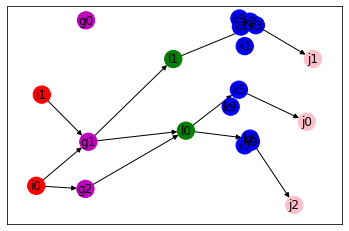

select warehouse: ['z_3', 'z_5', 'z_6']


In [96]:
# 实验所用模型
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import *
import math
import networkx as nx

np.random.seed(30)

class DataGet():
    def __init__(self):
        self.num_i = 2
        self.num_g = 3
        self.num_l = 2
        self.num_k = 10
        self.num_j = 3
        self.fixed_cost = np.random.randint(1e5,1e7,self.num_k)
        self.q_ij = np.random.randint(1000,10000,self.num_i*self.num_j).reshape(self.num_i,self.num_j)
        self.alpha = 0.5
        self.beta = 0.8
        self.expect_num_k = 3
        
    def generate_loc(self,num,x_value_range,y_value=500):
        x_loc = np.random.randint(x_value_range[0],x_value_range[1],num)
        y_loc = np.random.randint(0,y_value,num)
        locaiton = np.vstack((x_loc,y_loc)).T
        return locaiton

    def get_euclidean_distance_matrix(self,locationA,locationB):
        distances = {}
        for from_counter,from_node in enumerate(locationA):
            distances[from_counter] = {}
            for to_counter,to_node in enumerate(locationB):
                distances[from_counter][to_counter]=(math.hypot((from_node[0] - to_node[0]),(from_node[1] - to_node[1])))
        return distances
    
    def generate_node(self):
        self.i_loc = self.generate_loc(num=self.num_i,x_value_range=[0,100])
        self.g_loc = self.generate_loc(num=self.num_g,x_value_range=[200,300])
        self.l_loc = self.generate_loc(num=self.num_l,x_value_range=[400,600])
        self.k_loc = self.generate_loc(num=self.num_k,x_value_range=[700,800])
        self.j_loc = self.generate_loc(num=self.num_j,x_value_range=[900,1000])
        self.c_ig = self.get_euclidean_distance_matrix(self.i_loc,self.g_loc)
        self.c_gl = self.get_euclidean_distance_matrix(self.g_loc,self.l_loc)
        self.c_lk = self.get_euclidean_distance_matrix(self.l_loc,self.k_loc)
        self.c_kj = self.get_euclidean_distance_matrix(self.k_loc,self.j_loc)
        
    def solver_gp(self):
        model = Model('YUjINYan')
        x_iglkj = {}
        z_k = {}
        z_kj = {}
        for i in range(self.num_i):
            for g in range(self.num_g):
                for l in range(self.num_l):
                    for k in range(self.num_k):
                        for j in range(self.num_j):
                            name = 'x_' + str(i) + str(g) + str(l) + str(k) + str(j)
                            x_iglkj[i,g,l,k,j] = model.addVar(0,1,vtype=GRB.BINARY,name=name)
        for k in range(self.num_k):
            name = 'z_'+str(k)
            z_k[k] = model.addVar(0,1,vtype= GRB.BINARY,name= name)
        for k in range(self.num_k):
            for j in range(self.num_j):
                name = 'z_'+str(k)+str(j)
                z_kj[k,j] = model.addVar(0,1,vtype= GRB.BINARY,name= name)
        model.update()

        obj1 = LinExpr(0)
        obj2 = LinExpr(0)
        for i in range(self.num_i):
            for g in range(self.num_g):
                for l in range(self.num_l):
                    for k in range(self.num_k):
                        for j in range(self.num_j):
                            obj1.addTerms(self.q_ij[i,j]*(self.c_ig[i][g]+self.alpha*self.c_gl[g][l]+ self.beta*self.c_lk[l][k]+self.c_kj[k][j]),x_iglkj[i,g,l,k,j])
        for k in range(self.num_k):
            obj2.addTerms(self.fixed_cost[k],z_k[k])
            model.setObjective(obj1+obj2, GRB.MINIMIZE)
            
        # 货物只经过一次国内港口、国外港口、仓库
        lhs = LinExpr(0)
        for i in range(self.num_i):
            for j in range(self.num_j):
                for g in range(self.num_g):
                    for l in range(self.num_l):
                        for k in range(self.num_k):
                            lhs.addTerms(1, x_iglkj[i,g,l,k,j])
                model.addConstr(lhs == 1, name= 'visit harbour once'+str(i)+str(g)+str(l)+str(k)+str(j))
                lhs.clear()

        # 客户j由k负责，i到j一定经过k
        lhs = LinExpr(0)
        for i in range(self.num_i):
            for j in range(self.num_j):
                for k in range(self.num_k):
                    for g in range(self.num_g):
                        for l in range(self.num_l):
                            lhs.addTerms(1, x_iglkj[i,g,l,k,j])
                    model.addConstr(lhs <= z_kj[k,j], name= 'k warehouse decision'+str(i)+str(g)+str(l)+str(k)+str(j))
                    lhs.clear()

        # 每个客户只有一个仓库负责配送，一个j对应一个k
        lhs = LinExpr(0)
        for j in range(self.num_j):
            for k in range(self.num_k):
                lhs.addTerms(1, z_kj[k,j])
            model.addConstr(lhs == 1, name= 'one warehouse for one custumer'+str(k)+str(j))
            lhs.clear()
        
        # 配送需要的仓库小于等于选定的仓库
        lhs = LinExpr(0)
        for k in range(self.num_k):
            for j in range(self.num_j):
                lhs.addTerms(1, z_kj[k,j])
            model.addConstr(lhs <= z_k[k], name= 'warehouse limitation'+str(k)+str(j))
            lhs.clear()
        
        # 期望的海外仓库数量
        lhs = LinExpr(0)
        for k in range(self.num_k):
            lhs.addTerms(1, z_k[k])
        model.addConstr(lhs == self.expect_num_k, name= 'the number of warehouse'+str(k))
        
        model.setParam("OutputFlag",1) # 输出模型信息
        model.optimize()
        return model
    
    def get_route(self,model):
        route,z_set = [],[]
        if model.Status==2:
            for item in model.getVars():
                if item.x == 1 and item.varname[0]=='x':
                    route_=[]
                    for n,temp_name in enumerate(item.varname[2::]):
                        if n < 4:
                            route_.append(temp_name)
                        else:
                            route_.append(item.varname[6::])
                            break
                        route.append(route_)
                elif item.x == 1 and item.varname[0]=='z' and len(item.varname)<4:
                        z_set.append(item.varname)
        else:
            print('no solution!!!')
        return route,z_set
    
    def plot_route(self,route):
        Graph = nx.DiGraph()
        node_name = ['i','g','l','k','j']
        node_num = [self.num_i,self.num_g,self.num_l,self.num_k,self.num_j]
        locs = [self.i_loc,self.g_loc,self.l_loc,self.k_loc,self.j_loc]
        color_dict = ['r','m','g','b','pink']
        pos_location={}
        nodes_color_dict=[]
        for n,name in enumerate(node_name):
            nodes_name_temp = [name+str(_) for _ in range(node_num[n])]
            Graph.add_nodes_from(nodes_name_temp)
            nodes_color_dict += [color_dict[n] for _ in range(node_num[n])]
            for i,loc in enumerate(locs[n]):
                pos_location[nodes_name_temp[i]] = loc
        
        edges = []
        for r in route:
            edge = []
            for cnt,n_r in enumerate(r):
                r_temp = node_name[cnt] + n_r
                edge.append(r_temp)
                if len(edge) == 2 :
                    edges.append(tuple(edge))
                    edge.pop(0)
        Graph.add_edges_from(edges)
        nx.draw_networkx(Graph,pos_location,node_size=300,node_color=nodes_color_dict,labels=None)
        plt.show()
        
        
if __name__=='__main__':
    data = DataGet()
    data.generate_node()
    solution = data.solver_gp()
    route,z_set = data.get_route(solution)
    data.plot_route(route)
    print('select warehouse:',z_set)

In [31]:
# 扩展案例1
import gurobipy as gb
production,a=gb.multidict({'A1':200,'A2':300})
sales,b=gb.multidict({'B1':150,'B2':150,'B3':200})
route,cost = gb.multidict({('A1','B1'):16,('A1','B2'):4,('A1','B3'):16,('A2','B1'):26,('A2','B2'):15,('A2','B3'):5})
m = gb.Model("lp4")
x = {}
for i,j in route:
    x[i,j] = m.addVar(vtype=gb.GRB.INTEGER)# 构建决策变量x为整数
obj = gb.quicksum(x[i,j]*cost[i,j] for i,j in route)# 目标函数
m.setObjective(obj)
x = gb.tupledict(x)
m.addConstrs((x.sum("*",j) == b[j] for j in sales), name="con1")# 添加约束条件1
m.addConstrs((x.sum(i,"*") == a[i] for i in production), name="con2")# 添加约束条件2
m.write("lp4.lp")
m.optimize()
for v in m.getVars():
    print("%s %g" % (v.varName,v.x))
print("Obj:%g" % m.objVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xb2694f3e
Variable types: 0 continuous, 6 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 3e+02]
Presolve removed 5 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 5000 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+03, best bound 5.000000000000e+03, gap 0.0000%
C0 50
C1 150
C2 0
C3 100
C4 0
C5 200
Obj:5000


In [16]:
# 扩展案例2
import gurobipy as gb

production, a = gb.multidict({'A1': 7, 'A2': 4, 'A3': 9})  # 产地
sales, b = gb.multidict({'B1': 3, 'B2': 6, 'B3': 5, 'B4': 6})  # 销地
route, cost = gb.multidict({
    ('A1', 'B1'): 3,
    ('A1', 'B2'): 11,
    ('A1', 'B3'): 3,
    ('A1', 'B4'): 10,
    ('A2', 'B1'): 1,
    ('A2', 'B2'): 9,
    ('A2', 'B3'): 2,
    ('A2', 'B4'): 8,
    ('A3', 'B1'): 7,
    ('A3', 'B2'): 4,
    ('A3', 'B3'): 10,
    ('A3', 'B4'): 5})  # 单位运价

m = gb.Model("lp4")  # 构建模型
x = {}
for i, j in route:
    x[i, j] = m.addVar(vtype=gb.GRB.INTEGER)  # 构建决策变量x为整数

obj = gb.quicksum(x[i, j] * cost[i, j] for i, j in route)  # 目标函数
m.setObjective(obj)  # 默认最小化. 最大化则添加参数 gb.GRB.MAXIMIZE

x = gb.tupledict(x)
m.addConstrs((x.sum("*", j) == b[j] for j in sales), name="con1")  # 添加约束条件1
m.addConstrs((x.sum(i, "*") == a[i]for i in production), name="con2")  # 添加约束条件2

m.write("lp4.lp")

m.optimize()  # 求解

for v in m.getVars():
    print("%s %g" % (v.varName, v.x))
print("Obj: %g" % m.objVal)


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 12 columns and 24 nonzeros
Model fingerprint: 0x8d98905f
Variable types: 0 continuous, 12 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 9e+00]
Found heuristic solution: objective 172.0000000
Presolve time: 0.01s
Presolved: 7 rows, 12 columns, 24 nonzeros
Variable types: 0 continuous, 12 integer (0 binary)

Root relaxation: objective 8.500000e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      85.0000000   85.00000  0.00%     -    0s

Ex

In [3]:
# 扩展案例3
from __future__ import print_function
from __future__ import division, print_function
from gurobipy import *
import numpy as np
import copy
import time

starttime = time.time()


#返回最优的路线
def reportMIP(model, Routes):
    if model.status == GRB.OPTIMAL:
        print("Best MIP Solution: ", model.objVal, "\n")
        var = model.getVars()
        for i in range(model.numVars):
            if (var[i].x > 0):
                print(var[i].varName, " = ", var[i].x)
                print("Optimal route:", Routes[i])


def getValue(var_dict, nodeNum):
    x_value = np.zeros([nodeNum, nodeNum])
    for key in var_dict.keys():
        a = key[0]
        b = key[1]
        x_value[a][b] = var_dict[key].x

    return x_value


def getRoute(x_value):
    x = copy.deepcopy(x_value)
    #     route_temp.append(0)
    previousPoint = 0
    route_temp = [previousPoint]
    count = 0
    while (count != len(x_value)-1):
        # print('previousPoint: ', previousPoint )
        if (x[previousPoint][count] > 0):
            previousPoint = count
            route_temp.append(previousPoint)
            count = 0
            continue
        else:
            count += 1
    route_temp.append(len(x_value)-1)
    return route_temp

if __name__ == "__main__":


    nodeNum =11

#距离矩阵
    cost =[[0,2,8,1,1000,1000,1000,1000,1000,1000,1000],[2,0,6,1000,1,1000,1000,1000,1000,1000,1000]
           ,[8,6,0,7,5,1,2,1000,1000,1000,1000],[1,1000,7,0,1000,1000,9,100,100,100,100],[100,1,5,100,0,3,100,2,100,100,100]
        ,[100,100,1,100,3,0,4,100,6,100,100],[100,100,2,9,100,4,0,100,3,1,100],[100,100,100,100,2,100,100,0,7,100,9]
        ,[100,100,100,100,100,6,3,7,0,1,2],[100,100,100,100,100,100,1,100,1,0,4],[100,100,100,100,100,100,100,100,9,2,4,0]]
    print("cost", cost)
    model = Model('TSP')

    # creat decision variables，决策变量
    X = {}
    for i in range(nodeNum):
        for j in range(nodeNum):
            if (i != j):
                X[i, j] = model.addVar(vtype=GRB.BINARY
                                       , name='x_' + str(i) + '_' + str(j)
                                       )

    # set objective function，目标函数

    obj = LinExpr(0)
    for key in X.keys():
        i = key[0]
        j = key[1]
        obj.addTerms(cost[key[0]][key[1]], X[key])

    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints 出发点的流量约束

    lhs_1 =LinExpr(0)
    lhs_2 =LinExpr(0)
    for j in range(1, nodeNum-1):
        for i in range(0,nodeNum):
              if i == 0:
                lhs_1.addTerms(1, X[i, j])
    model.addConstr(lhs_1 == 1, name='visit_' + str(i)+"start")

    #终点的流量约束
    for i in range(1,nodeNum-1):
        for j in range(1, nodeNum):
              if j == nodeNum-1:
                  lhs_2.addTerms(1, X[i, j])
    model.addConstr(lhs_2 == 1, name='visit_' + str(j) + "end")

    #其余点的流量约束
    for j in range(1,nodeNum-1):
        lhs3 = LinExpr(0)
        for i in range(0, nodeNum-1):
            if i != j:
                lhs3.addTerms(1, X[i, j])
        for i in range(1, nodeNum):
            if i != j:
                lhs3.addTerms(-1, X[j, i])
        model.addConstr(lhs3 == 0, name='visit_' + str(j)+'balance_flow')

    model.write('modelshortestpath.lp')
    model.setParam(GRB.Param.MIPGap, 0)
    model.setParam(GRB.Param.TimeLimit, 60)
    model.optimize()
    # 可以输出求解的决策变量
    print(model.ObjVal)
    X_NEW={}
    for var in model.getVars():
        if (var.x > 0):
            print(var.varName, '\t', var.x)
            X_NEW[var.varName]=var.x

    x_value = getValue(X, nodeNum)
    route = getRoute(x_value)
    print('optimal route:', route)
    

cost [[0, 2, 8, 1, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [2, 0, 6, 1000, 1, 1000, 1000, 1000, 1000, 1000, 1000], [8, 6, 0, 7, 5, 1, 2, 1000, 1000, 1000, 1000], [1, 1000, 7, 0, 1000, 1000, 9, 100, 100, 100, 100], [100, 1, 5, 100, 0, 3, 100, 2, 100, 100, 100], [100, 100, 1, 100, 3, 0, 4, 100, 6, 100, 100], [100, 100, 2, 9, 100, 4, 0, 100, 3, 1, 100], [100, 100, 100, 100, 2, 100, 100, 0, 7, 100, 9], [100, 100, 100, 100, 100, 6, 3, 7, 0, 1, 2], [100, 100, 100, 100, 100, 100, 1, 100, 1, 0, 4], [100, 100, 100, 100, 100, 100, 100, 100, 9, 2, 4, 0]]
Restricted license - for non-production use only - expires 2024-10-28
Set parameter MIPGap to value 0
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11 rows, 110 columns and 180 nonzeros
Model fingerprint: 0x898ca910